
# Chapter 4




# Lab: Logistic Regression, LDA, QDA, and KNN


# Classifiers

- We can predict the category by:
    - Directly estimating $P(Y=k | X)$
  or
    - Estimating $P(X | Y=k)$ and $P(Y=k)$ to get $P(Y=k | X)$
      
-----

- **Logistic regression**: Uses maximum likelihood to pick the best category, after having estimated $P(Y=k|X)$. **We want to maximize the probability of the samples being the ones that were actually drawn.**
    - $P(Y=1|X)$ -> Logistic function (S-shaped) $\frac{e^{\beta_0 + \beta_1 X}}{1+e^{\beta_0 + \beta_1 X}}$. Null hypothesis: $P(Y=1|X) = \frac{e^{\beta_0}}{1+e^{\beta_0}}$, meaning that the probability does not depend on X.
    - Odds -> Exponential function, $e^{\beta_0 + \beta_1 X}$
    - Logit / logodds -> $log(Odds)$ -> Linear function.
      
- **Multinomial Logistic regression**
    - **With a baseline class**
    - **Softmax**

- **Generative Models**: Uses Bayes to estimate $P(X | Y=k)$.
    - **Linear Discriminant Analysis**
    - **Quadratic Discriminant Analysis**
    - **Naive Bayes**

- **KNN**

## The Stock Market Data

In this lab we will examine the `Smarket` 
data, which is part of the `ISLP`
library. This data set consists of percentage returns for the S&P 500
stock index over 1,250 days, from the beginning of 2001 until the end
of 2005. For each date, we have recorded the percentage returns for
each of the five previous trading days,  `Lag1`  through
 `Lag5`. We have also recorded  `Volume`  (the number of
shares traded on the previous day, in billions),  `Today`  (the
percentage return on the date in question) and  `Direction`
(whether the market was  `Up`  or  `Down`  on this date).

We start by importing  our libraries at this top level; these are all imports we have seen in previous labs.

In [60]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize)

We also collect together the new imports needed for this lab.

In [61]:
from ISLP import confusion_table
from ISLP.models import contrast

from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


Now we are ready to load the `Smarket` data.

In [62]:
Smarket = load_data('Smarket')
Smarket

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,Up
...,...,...,...,...,...,...,...,...,...
1245,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,Up
1246,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,Down
1247,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,Up
1248,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,Down


In [63]:
Smarket[Smarket['Year']==2001].iloc[-1]

Year           2001
Lag1          0.336
Lag2          0.675
Lag3          0.412
Lag4         -0.021
Lag5          0.435
Volume       0.9174
Today        -1.115
Direction      Down
Name: 241, dtype: object

This gives a truncated listing of the data.
We can see what the variable names are.

In [64]:
Smarket.columns

Index(['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today',
       'Direction'],
      dtype='object')

We compute the correlation matrix using the `corr()` method
for data frames, which produces a matrix that contains all of
the pairwise correlations among the variables.
 
By instructing `pandas` to use only numeric variables, the `corr()` method does not report a correlation for the `Direction`  variable because it is
 qualitative.

In [65]:
Smarket.corr(numeric_only=True)


,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


As one would expect, the correlations between the lagged return  variables and
today’s return are close to zero.  The only substantial correlation is between  `Year`  and
 `Volume`. By plotting the data we see that  `Volume`
is increasing over time. In other words, the average number of shares traded
daily increased from 2001 to 2005.


<Axes: title={'center': 'uncorrelated'}, xlabel='Today', ylabel='Lag1'>

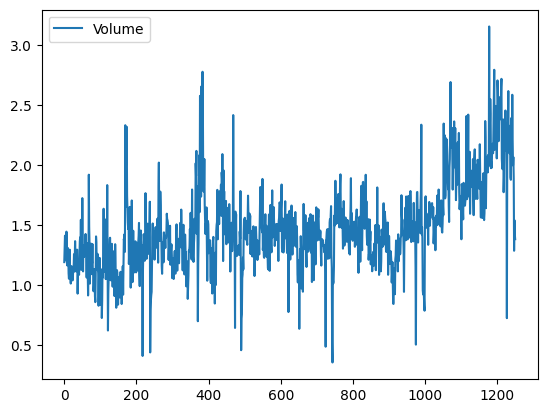

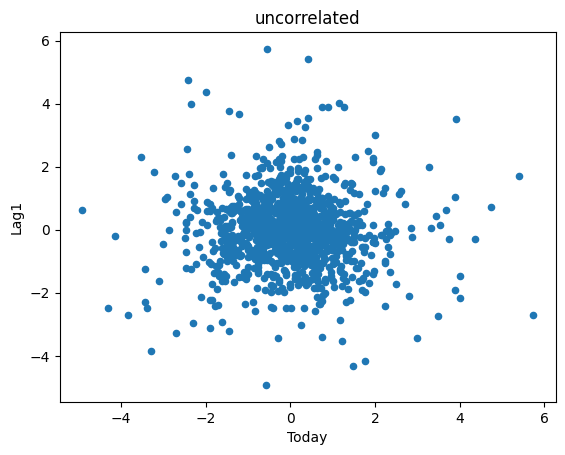

In [66]:
Smarket.plot(y='Volume');
Smarket.plot(x='Today', y='Lag1', kind='scatter', title='uncorrelated')

## Logistic Regression (As a General Linear Model, GLM)



### Generalized Linear Models
An extension for Linear Regression, but for different kinds of response variables and allowing for non-linear relationships between the response and predictors, but linear in the parameters. It models the **mean of the response** using a link function applied to a linear combination of predictors.
- Random component: The response variable as a distribution (Gaussian, Bernoulli, Poisson).
- Systematic Component: The linear predictor, $\eta = \beta_0 + \beta_1 x_1 + \cdot \cdot \cdot \beta_p x_p = \vec{X}\vec{\beta}$.
- Link function $g$, connecting the expected value of the response to the linear predictor $\eta$: $g(E(Y)) = \eta$.

The model won't make the output a linear function of the predictors, but just linear on the parameters $\beta$ _before_ applying the link function. So we _do_ have a linear predictor, $\eta$, but followed by a non-linear function $g$.

The fact that the linear predictor is indeed linear ensures that the cost function is convex in many cases, so there are no local minima and just one global minima, so it's easier to optimize.
#### Logistic Regression
Instead of modelling the variable $Y(x)$, it models $P(y \in category)$, by the use on a S-shaped, non-linear transformation.

- Random component: It's Bernoulli, given that the response $Y$ is binary (0 and 1), with $P(y=1)=p$ and $P(y=0)=1-p$, with mean $E[Y] = p$. The probability mass function is $f(y;p) = p^y (1-p)^{1-y}$, with $y \in \{0,1\}$.
- Systematic component: The linear predictor is $\eta = \vec{X}\vec{\beta}$, but $\eta$ can't be $p$ because they have different domains. We have to use a non-linear function to map this linear predictor into a non-linear function.
- Link function: We need to map $p \in (0,1)$ to $\eta \in (-\infty, \infty)$, so we define the $logit$ function:

$$
logit(p) = \log\left( \frac{p}{1-p}\right)
$$
so that $logit(p) = \vec{X}\vec{\beta} = \eta$: This is the non-linear function that ends up giving us a linear predictor: the logit is the one modeled as a linear function of the predictors. Solving for $p$ we get the logistic function in terms of $\vec{X}$ and $\vec{\beta}$: 
$$
p_0 = \frac{1}{1+e^{-\vec{X}\vec{\beta}}}; p_1 = \frac{e^{-\vec{X}\vec{\beta}}}{1+e^{-\vec{X}\vec{\beta}}}
$$ 
This is the **logistic function**, so $p$ has an S-shape between 0 and 1. **We have to find the _turning point_ where the probability density changes. This is changed by the $\beta_i$ values to be found.**

This $p$ is the one we would use for expressing the probability of the output we actually got, as it's still a set of Bernoullies we are talking about. The parameter $p$ in the Bernoulli is the one we aim to end up calculating.

So we can calculate the likelihood over all samples: Given the samples I got, the probability of having taken those samples is just 
$$
L(\beta_0, \vec{\beta}) = \prod_{i=1}^n P(Y=y_i | \vec{x_i}, \beta_0, \vec{\beta}) = \prod_{i=1}^n [P(Y=1|\vec{x_i}]^{y_i}[1-P(Y=1|\vec{x_i}]^{1-y_i}
$$
where $P(Y=1|\vec{x_i}$ is just $p$ as expressed above. The likelihood, although initially related to just $p$ for a Binomial distribution, is now dependent on $\beta$ through the logit function.

We then use the maximum likelihood to pick the best category, after having estimated $p=P(Y=k|X)$ in terms of $\beta$. **We want to maximize the probability of the samples being the ones that were actually drawn.** So we aim to maximize this function. In general, we prefer to minimize the neative log-likelihood, and gradient-based optimization methods can be used. This optimization methods work better (and are designed for) linear relationships.
    
Some definitions:
- Null hypothesis: $P(Y=1|X) = \frac{e^{\beta_0}}{1+e^{\beta_0}}$, meaning that the probability does not depend on X.
- Odds -> Exponential function, $\text{Odds} = \frac{p(x)}{1-p(x)} = e^{\beta_0 + \beta_1 X} = e^{\beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_p x_p}$
- Logit / logodds -> $log(Odds)$ -> Linear function: $\beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_p x_p$. **We can define a logit function that is linear, and this allows us to construct a linear model for that logit function, easily transformable to the odds one and then to $p(x)$.** --> This is a Generalized Linear Model (GLM).

- We use t-statistics instead of z-statistics.

- Logistic Regression is defined for two predictors.
    - More predictors: **Multiple Logistic Regression**.
    - Multiple classes: **Multinomial Logistic Regression**.
        - Using a **baseline class**
        - Or using **Softmax**

### Multinominal Logistic Regression
- Outcome has now K values (categories).
- Each observation belongs to just 1 class.

In order to reuse the previous analysis, we end up modeling each class against the baseline class, identifying that the logit is linear relative to the baseline class.
$$
\log\left(\frac{p_k}{p_0}\right) = \vec{X}\vec{\beta_k}
$$
with $\vec{\beta_k}$ depends on the class $k$ at hand.
We can then calcualte the probabilities, given the fact that $\sum_{k=0}^{K-1} p_k = 1 \therefore p_0 + \sum_{k=1}^{K-1} p_k = 1$ and that from the previous expression, $p_k = p_0 e^{\vec{X}\vec{\beta_k}}$. Substituting:
$$
\begin{align}
p_0 e^{\vec{X}\vec{\beta_k}} &= p_0 \left( 1+ \sum_{k=1}^{K-1} e^{\vec{X}\vec{\beta_k}} \right) = 1 \\
p_0 &= \frac{1}{1+\sum_{k=1}^{K-1} e^{\vec{X}\vec{\beta_k}}} \\
p_k &= p_0 e^{\vec{X}\vec{\beta_k}} = \frac{e^{\vec{X}\vec{\beta_k}}}{1+\sum_{k=1}^{K-1} e^{\vec{X}\vec{\beta_k}}}, k=1, ..., K-1
\end{align}
$$

Then we again aim to maximize the likelihood of the data, but now
$$
\log(L(\beta)) = \sum_{i=1}^n \sum_{k=0}^{K-1} y_{ik} \log(p_k(X_i)), \text{ where } y_{ik}=1 \text{ if } \text{ sample } i \in \text{ class } k
$$

Next, we will fit a logistic regression model in order to predict
 `Direction`  using  `Lag1`  through  `Lag5`  and
 `Volume`. The `sm.GLM()`  function fits *generalized linear models*, a class of
models that includes logistic regression.  Alternatively,
the function `sm.Logit()` fits a logistic regression
model directly. The syntax of
`sm.GLM()` is similar to that of `sm.OLS()`, except
that we must pass in the argument `family=sm.families.Binomial()`
in order to tell `statsmodels` to run a logistic regression rather than some other
type of generalized linear model.

```mermaid
flowchart LR
     Statsmodels --> ols("OLS(samples,correct_values)") --> lr("Linear Regression")
     Statsmodels --> glm["GLM(samples,correct_values)"] --"family=sm.families.Binomial()" --> logr["Logistic Regression"]
     glm --"family=sm.families.Gaussian()"--> lr
     glm --"family=sm.families.Poisson()"--> Counting
```

In [67]:
allvars = Smarket.columns.drop(['Today', 'Direction', 'Year'])

# ModelSpec is a transform. This transform adds an intercept column.
design = MS(allvars) 

# As a transform, we can make fit_transform
X = design.fit_transform(Smarket)
print(X.columns)

# We filter to consider only those cases in which the market went up. That's gonna be the TRUE value.
y = Smarket.Direction == 'Up'

glm = sm.GLM(y,  # Just like with OLS, first the response (y, true or false)
             X,  # Then the matrix of predictors, already transformed (with an intercept!)
             family=sm.families.Binomial()) # And we have to add the family. Binomial because we want to classify (logistic regression)

# Having defined the model, we have to fit it.
results = glm.fit()
summarize(results)

Index(['intercept', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume'], dtype='object')


,coef,std err,z,P>|z|
intercept,-0.1260,0.241,-0.523,0.601
Lag1,-0.0731,0.050,-1.457,0.145
Lag2,-0.0423,0.050,-0.845,0.398
Lag3,0.0111,0.050,0.222,0.824
Lag4,0.0094,0.050,0.187,0.851
Lag5,0.0103,0.050,0.208,0.835
Volume,0.1354,0.158,0.855,0.392


<Axes: title={'center': 'uncorrelated'}, xlabel='Lag1', ylabel='Direction'>

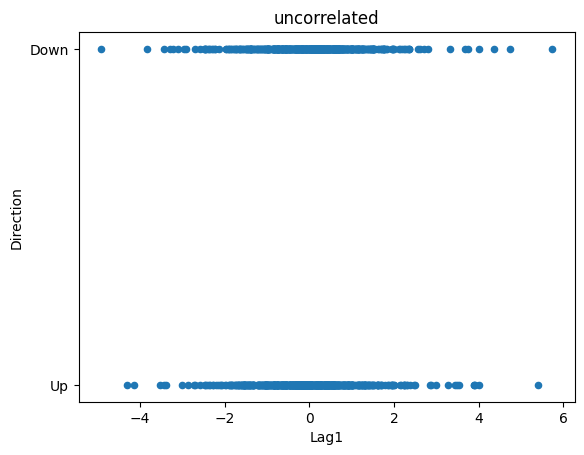

In [68]:
Smarket.plot(x='Lag1', y='Direction', kind='scatter', title='uncorrelated')

The smallest *p*-value here is associated with  `Lag1`. The
negative coefficient for this predictor suggests that if the market
had a positive return yesterday, then it is less likely to go up
today. However, at a value of 0.15, the *p*-value is still
relatively large, and so there is no clear evidence of a real
association between  `Lag1`  and  `Direction`.

We use the `params`  attribute of `results`
in order to access just the
coefficients for this fitted model.

In [69]:
results.params


intercept   -0.126000
Lag1        -0.073074
Lag2        -0.042301
Lag3         0.011085
Lag4         0.009359
Lag5         0.010313
Volume       0.135441
dtype: float64

Likewise we can use the
`pvalues`  attribute to access the *p*-values for the coefficients.

In [70]:
results.pvalues


intercept    0.600700
Lag1         0.145232
Lag2         0.398352
Lag3         0.824334
Lag4         0.851445
Lag5         0.834998
Volume       0.392404
dtype: float64

The `predict()`  method of `results` can be used to predict the
probability that the market will go up, given values of the
predictors. This method returns predictions
on the probability scale. If no data set is supplied to the `predict()`
function, then the probabilities are computed for the training data
that was used to fit the logistic regression model.
As with linear regression, one can pass an optional `exog` argument consistent
with a design matrix if desired. Here we have
printed only the first ten probabilities.

In [71]:
probs = results.predict()
probs[:10]


array([0.50708413, 0.48146788, 0.48113883, 0.51522236, 0.51078116,
       0.50695646, 0.49265087, 0.50922916, 0.51761353, 0.48883778])

In order to make a prediction as to whether the market will go up or
down on a particular day, we must **convert these predicted
probabilities into class labels**,  `Up`  or  `Down`.  The
following two commands create a vector of class predictions based on
whether the predicted probability of a market increase is greater than
or less than 0.5.

In [72]:
labels = np.array(['Down']*1250)
labels[probs>0.5] = "Up"


### With ScikitLearn

We should do this using ScikitLearn too, so we don't depend on the custom library.

In [73]:
from sklearn.linear_model import LogisticRegression

# Default parameters:
#    solver='lbfgs' (default solver)
#        Good choice for small-to-medium datasets
#        Handles L2 regularization well
#        Reasonably fast and memory efficient
#    penalty='l2' (default regularization)
#        Ridge regression-style penalty
#        Shrinks coefficients toward zero but doesn't eliminate features
#        Contrast with l1 (Lasso) which can zero out coefficients
#    max_iter=100 (default iterations)
#        Maximum optimization iterations
#        With weak regularization (C=1000), might need more iterations

clf = LogisticRegression(
                       dual=False, # To solve the primal problem, and not the dual one.
                       C=1000,  # to make regularization very weak, allowing for complex models  (λ = 1/C)
                       fit_intercept=True # To make it calculate the intercept
                      ).fit(Smarket[['Lag1','Lag2']],   # the model parameters matrix
                            Smarket['Direction']=='Up') # The results

In [74]:
clf.predict(X[['Lag1','Lag2']])[:10]

array([ True, False, False,  True,  True,  True, False,  True,  True,
       False])

In [75]:
clf.classes_

array([False,  True])

In [76]:
clf.predict_proba(X[['Lag1','Lag2']])[:10]
# Prob de False, Prob de True (orden de clf.classes_)

array([[0.48612116, 0.51387884],
       [0.50282029, 0.49717971],
       [0.51054369, 0.48945631],
       [0.48175982, 0.51824018],
       [0.48550292, 0.51449708],
       [0.49206435, 0.50793565],
       [0.50869908, 0.49130092],
       [0.48968657, 0.51031343],
       [0.4774573 , 0.5225427 ],
       [0.5050421 , 0.4949579 ]])

In [77]:
clf.score(X[['Lag1','Lag2']],y)

# The score is executed after having fit the model.
# clf can calculate the predicted values for the X values it receives as a first param.
# and as a second param, with the correct values, it can calculate the score, which is by default  (correct predictions / total samples)

0.528

### Confusion table

The `confusion_table()`
function from the `ISLP` package summarizes these predictions, showing   how
many observations were correctly or incorrectly classified. Our function, which is adapted from a similar function
in the module `sklearn.metrics`,  transposes the resulting
matrix and includes row and column labels.
The `confusion_table()` function takes as first argument the
predicted labels, and second argument the true labels.

In [78]:
confusion_table_smarket = confusion_table(labels,            # From predictions
                                  Smarket.Direction) # From measured values
confusion_table_smarket

Truth,Down,Up
Predicted,,
Down,145,141
Up,457,507


In [79]:
confusion_table_smarket['Total'] = confusion_table_smarket['Down'] + confusion_table_smarket['Up']
confusion_table_smarket

Truth,Down,Up,Total
Predicted,,,
Down,145,141,286
Up,457,507,964


In [80]:
np.sum(confusion_table_smarket['Down'])

602

In [81]:
confusion_table_smarket.loc['Total'] = [np.sum(confusion_table_smarket['Down']),
                                        np.sum(confusion_table_smarket['Up']),
                                        np.sum(confusion_table_smarket['Total']),
                                        ]
confusion_table_smarket

Truth,Down,Up,Total
Predicted,,,
Down,145,141,286
Up,457,507,964
Total,602,648,1250


In [82]:
confusion_table_smarket['Down']

Predicted
Down     145
Up       457
Total    602
Name: Down, dtype: int64

In [83]:
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
sk_confusion_matrix(Smarket.Direction, labels)
# Note how they are swapped/transposed.

array([[145, 457],
       [141, 507]])

**The diagonal elements of the confusion matrix indicate correct
predictions, while the off-diagonals represent incorrect
predictions.** Hence our model correctly predicted that the market would
go up on 507 days and that it would go down on 145 days, for a
total of 507 + 145 = 652 correct predictions. The `np.mean()`
function can be used to compute the fraction of days for which the
prediction was correct. In this case, logistic regression correctly
predicted the movement of the market 52.2% of the time.


In [84]:
(507+145)/1250, np.mean(labels == Smarket.Direction)

(0.5216, 0.5216)

At first glance, it appears that the logistic regression model is
working a little better than random guessing. However, this result is
misleading because we trained and tested the model on the same set of
1,250 observations. In other words, $100-52.2=47.8%$ is the
*training* error  rate. As we have seen
previously, the training error rate is often overly optimistic --- it
tends to underestimate the test error rate.  In
order to better assess the accuracy of the logistic regression model
in this setting, we can fit the model using part of the data, and
then examine how well it predicts the *held out* data.  This
will yield a more realistic error rate, in the sense that in practice
we will be interested in our model’s performance not on the data that
we used to fit the model, but rather on days in the future for which
the market’s movements are unknown.

To implement this strategy, we first create a Boolean vector
corresponding to the observations from 2001 through 2004. We  then
use this vector to create a held out data set of observations from
2005.

In [85]:
train = (Smarket.Year < 2005) # create the filter
Smarket_train = Smarket.loc[train]
Smarket_test = Smarket.loc[~train]
Smarket_test.shape


(252, 9)

The object `train` is a vector of 1,250 elements, corresponding
to the observations in our data set. The elements of the vector that
correspond to observations that occurred before 2005 are set to
`True`, whereas those that correspond to observations in 2005 are
set to `False`.  Hence `train` is a
*boolean*   array, since its
elements are `True` and `False`.  Boolean arrays can be used
to obtain a subset of the rows or columns of a data frame
using the `loc` method. For instance,
the command `Smarket.loc[train]` would pick out a submatrix of the
stock market data set, corresponding only to the dates before 2005,
since those are the ones for which the elements of `train` are
`True`.  The `~` symbol can be used to negate all of the
elements of a Boolean vector. That is, `~train` is a vector
similar to `train`, except that the elements that are `True`
in `train` get swapped to `False` in `~train`, and vice versa.
Therefore, `Smarket.loc[~train]` yields a
subset of the rows of the data frame
of the stock market data containing only the observations for which
`train` is `False`.
The output above indicates that there are 252 such
observations.

We now fit a logistic regression model using only the subset of the
observations that correspond to dates before 2005. We then obtain predicted probabilities of the
stock market going up for each of the days in our test set --- that is,
for the days in 2005.

In [86]:
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]

glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())  # Logistic!

results = glm_train.fit()

probs = results.predict(exog=X_test)


Notice that we have trained and tested our model on two completely
separate data sets: training was performed using only the dates before
2005, and testing was performed using only the dates in 2005.

Finally, we compare the predictions for 2005 to the
actual movements of the market over that time period.
We will first store the test and training labels (recall `y_test` is binary).

In [87]:
D = Smarket.Direction
L_train, L_test = D.loc[train], D.loc[~train]


Now we threshold the
fitted probability at 50% to form
our predicted labels.

In [88]:
labels = np.array(['Down']*252)
labels[probs>0.5] = 'Up'
confusion_table(labels, L_test)


Truth,Down,Up
Predicted,,
Down,77,97
Up,34,44


The test accuracy is about 48% while the error rate is about 52%

In [89]:
np.mean(labels == L_test), np.mean(labels != L_test)


(0.4801587301587302, 0.5198412698412699)

The `!=` notation means *not equal to*, and so the last command
computes the test set error rate. The results are rather
disappointing: the test error rate is 52%, which is worse than
random guessing! Of course this result is not all that surprising,
given that one would not generally expect to be able to use previous
days’ returns to predict future market performance. (After all, if it
were possible to do so, then the authors of this book would be out
striking it rich rather than writing a statistics textbook.)

We recall that the logistic regression model had very underwhelming
*p*-values associated with all of the predictors, and that the
smallest *p*-value, though not very small, corresponded to
 `Lag1`. Perhaps by removing the variables that appear not to be
helpful in predicting  `Direction`, we can obtain a more
effective model. After all, **using predictors that have no relationship
with the response tends to cause a deterioration in the test error
rate (since such predictors cause an increase in variance without a
corresponding decrease in bias)**, and so removing such predictors may
in turn yield an improvement.  Below we refit the logistic
regression using just  `Lag1`  and  `Lag2`, which seemed to
have the highest predictive power in the original logistic regression
model.

In [90]:
model = MS(['Lag1', 'Lag2']).fit(Smarket)
X = model.transform(Smarket)
X_train, X_test = X.loc[train], X.loc[~train]
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)
labels = np.array(['Down']*252)
labels[probs>0.5] = 'Up'
confusion_table(labels, L_test)


Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


Let’s evaluate the overall accuracy as well as the accuracy within the days when
logistic regression predicts an increase.

In [91]:
(35+106)/252,106/(106+76)


(0.5595238095238095, 0.5824175824175825)

Now the results appear to be a little better: 56% of the daily
movements have been correctly predicted. It is worth noting that in
this case, a much simpler strategy of predicting that the market will
increase every day will also be correct 56% of the time! Hence, in
terms of overall error rate, the logistic regression method is no
better than the naive approach. However, the confusion matrix
shows that on days when logistic regression predicts an increase in
the market, it has a 58% accuracy rate. This suggests a possible
trading strategy of buying on days when the model predicts an
increasing market, and avoiding trades on days when a decrease is
predicted. Of course one would need to investigate more carefully
whether this small improvement was real or just due to random chance.

Suppose that we want to predict the returns associated with particular
values of  `Lag1`  and  `Lag2`. In particular, we want to
predict  `Direction`  on a day when  `Lag1`  and
 `Lag2`  equal $1.2$ and $1.1$, respectively, and on a day when they
equal $1.5$ and $-0.8$.  We do this using the `predict()`
function.

In [92]:
newdata = pd.DataFrame({
                        'Lag1':[1.2, 1.5],
                        'Lag2':[1.1, -0.8]
                       });
newX = model.transform(newdata)
results.predict(newX)

0    0.479146
1    0.496094
dtype: float64

/home/jovyan/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


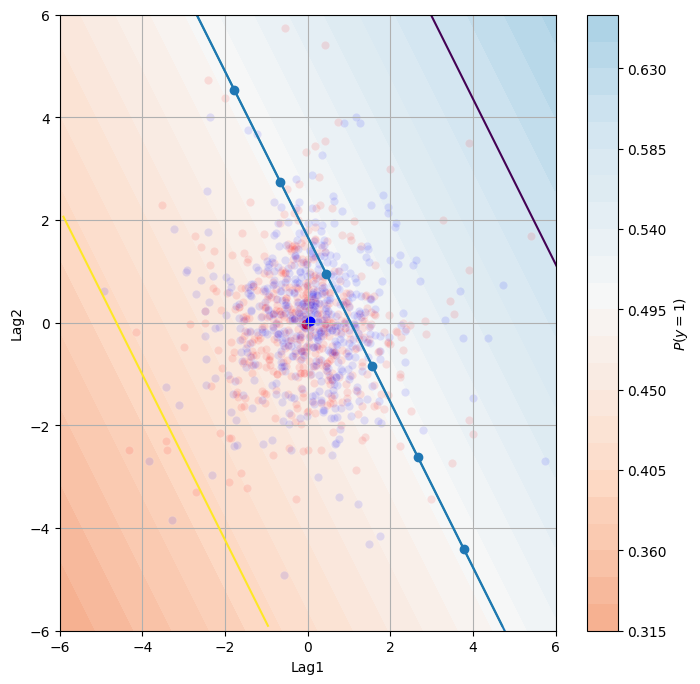

In [93]:
from matplotlib.pyplot import subplots
from sklearn.inspection import DecisionBoundaryDisplay

fig, ax = subplots(figsize=(8, 8))

complete_train_set = X_train.copy()
complete_train_set['result'] = y_train

# Lets make the grid!
xx, yy = np.mgrid[-6:6:.01,
                  -6:6:.01]
grid = np.c_[xx.ravel(), yy.ravel()]

# Predict outcome for every single point in the mesh
probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)

# Plot the results for all points in the grid
contour = ax.contourf(xx, yy, 1-probs, 25,
                      cmap="RdBu", vmin=0, vmax=1)
ax_c = fig.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
#ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(complete_train_set[complete_train_set['result']==True]['Lag1'], 
           complete_train_set[complete_train_set['result']==True]['Lag2'], 
           color='r', alpha=0.1, edgecolor="white")
ax.scatter(complete_train_set[complete_train_set['result']==True]['Lag1'].mean(),
           complete_train_set[complete_train_set['result']==True]['Lag2'].mean(),
           color='r')
ax.scatter(complete_train_set[complete_train_set['result']==False]['Lag1'], 
           complete_train_set[complete_train_set['result']==False]['Lag2'], 
           color='b', alpha=0.1, edgecolor="white",)
ax.scatter(complete_train_set[complete_train_set['result']==False]['Lag1'].mean(),
           complete_train_set[complete_train_set['result']==False]['Lag2'].mean(),
           color='b')


DecisionBoundaryDisplay.from_estimator(
        clf,
        X[['Lag1','Lag2']],
        response_method="predict_proba",
        plot_method="contour",
        ax=ax,
        alpha=1.0,
        levels=[0.4, 0.5, 0.6]
    )

# The decision boundary, as calculated from
# coeff_ \cdot x + intercept = 0
# coeff and intercept are general for any method.
x_lag1_axis = np.linspace(-4,6,10)
ax.plot(x_lag1_axis,
        -clf.coef_[0][0]/clf.coef_[0][1]*x_lag1_axis - clf.intercept_/clf.coef_[0][1],
        marker='o')
# Both the decision boundary and the handcrafted line provide the same result.

ax.set_xlim([-6,6])
ax.set_ylim([-6,6])

ax.grid(True)

## Generative Models

Instead of calculating $P(Y=k|_{X=x})$, we estimate it using Bayes' Theorem from the simpler-to-calculate $P(X=x|_{Y=k})$. Once $P(Y=k|_{X=x})$ is estimated, we just look for it's maximum, just like in Logistic Regression.

From Bayes we know that:
$$
\begin{align}
P(X|_{y}) \cdot P(y) = P(y|_{X}) \cdot P(X) \therefore P(y|_{X}) = \frac{P(X|_{y}) \cdot P(y)}{P(X)} \\
\end{align}
$$

And the Total Probability Theorem tells us that
$$
P(X=x) = \sum_{\forall y} P(X=x|_{y}) \cdot P(y)
$$

And therefore,
$$
P(Y=k|_{X=x}) = \frac{P(X=x|_{Y=k}) \cdot P(Y=k)}{\sum_{l=1}^{K} P(X=x|_{y=l}) \cdot P(y=l)} =  \frac{\pi_k \cdot f_k(x)}{\sum_{l=1}^{k} \pi_l \cdot f_l(x)}\\
$$

We can then estimate
- **A priori** probability of the class $i$ as $\pi_i$. In particular, $P(y=k) = \pi_k$.
    - This estimation can be performed considering the ratio of observations that are from each class.
- $P(X=x|_{y=k})$ is the **a posteriori** probability, also noted $f_k(X)$. This can be estimated by assuming $f_k(X)$ form or by using non-parametric estimations. Three main ways are studied:
    - **Linear Discriminant Analysis (LDA)**: $f_k(X)$ is considered **Gaussian**, with **each predictor having the same variance** $\sigma^2=\sigma_1^2=...=\sigma_p^2$. Few coefficients have to be estimated: The mean for each class, $\mu_k$, and $\sigma$ itself. Therefore, it's prefered when $n$ is small and decision boundaries are linear.
        -  A simplification (linear) is possible. We know that the probability is supposed to be Gaussian, and therefore we can express it like:
          $$
            p_k(x) \propto \pi_k \frac{1}{\sqrt{2 \pi}\sigma} \exp{\left(-\frac{1}{2\sigma^2}(x-\mu_k)^2\right)}
          $$
        We want to maximize that but we can take logs on both sides, ditch all terms that are independent of $k$, and then we have to maximize
          $$
            d_k(x)= \log(p_k(x)) \propto  x\frac{\mu_k}{\sigma^2} - \frac{\mu_k^2}{2 \sigma^2} + \log(\pi_k)
          $$
        $$ 
            \begin{align}
                \hat{\mu_k} &= \frac{1}{n_k} \sum_{y_i=k} x_i \text{ (the mean of the samples for that category)}\\ 
                \hat{\sigma} &= \frac{1}{n-k} \sum_{k=1}^{n} \sum_{i/y_i=k} (x_i-\hat{\mu_k})^2
            \end{align}
          $$
    
    So we decide for the class fot which the $d_k(x)$ is greater.

    On a more general way:
          $$
            \delta_k(\mathbf{x}) = \mathbf{x}^T \boldsymbol{\Sigma}^{-1} \boldsymbol{\mu}_k - \frac{1}{2} \boldsymbol{\mu}_k^T \boldsymbol{\Sigma}^{-1} \boldsymbol{\mu}_k + \log P(Y=k)
          $$

    - **Quadratic Discriminant Analysis (QDA)**: $f_k(X)$ is considered **Gaussian**, but now **each class has its own covariance matrix**, $\Sigma_k$, so that $x \approx N(\mu_k, \Sigma_k)$, and therefore more coefficients have to be found ($\frac{p(p+1)}{2} \cdot k$), providing **more flexibility** along with **more variance**, as it considers interaction between predictors. Requires several observations, but **can predict non-linear decision boundaries**.
 
    The expression for the discriminant function is:
         $$
           \delta_k(\mathbf{x}) = -\frac{1}{2} \log|\boldsymbol{\Sigma}_k| - \frac{1}{2} (\mathbf{x} - \boldsymbol{\mu}_k)^T \boldsymbol{\Sigma}_k^{-1} (\mathbf{x} - \boldsymbol{\mu}_k) + \log P(Y=k)
         $$
      
    - **Naive Bayes**: Assumes that $f_k(x)$ for each class are **independent**, and therefore the density function is the product of the density function for each separate classes ($f_k(x) = f_{k1}(x) \cdot f_{k2}(x) \cdot \cdot \cdot f_{kp}(x)$), and each $f_{ki}$ has to be estimated separately. The estimation can be parametric (for example, assuming that $X_y$ has a normal distribution, and reaching similar results to QDA, but with a diagonal matrix as covariance matrix, due to independence) or non-parametric (using histograms or kernel density functions in the case of quantitative variables, and counting the percentage of observations pertaining to each class for each predictor in the case of qualitative ones). Boundaries may be non-linear.

```mermaid
flowchart TD
Classif((Classification)) --> LR(Logistic Regression)
glm[/"Generalized Linear Model"/] --> LR
glm --> LinReg("Linear Regression")
glm --> PR("Poisson Regression")
Classif --> GM[("Generative models")] --> priori("A priori") --> Ratio
GM --> posteriori("A posteriori") --> LDA{{"Linear Discriminant Analysis"}} --> gsv["Gaussian, same variance"]
posteriori --> QDA{{"Quadratic Discriminant Analysis"}} --> gdv["Gaussian, differente variances"]
posteriori --> NB{{"Naive Bayes"}} --> indep["Independendent"]
NB --> param("Parametric")
NB --> nparam("Non parametric")
Classif --> KNN
```

### Linear Discriminant Analysis

```mermaid
flowchart TD
posteriori("a posteriori") --> gaussian("Gaussian")
posteriori --> ni("Not independent")
posteriori --> samevar("Same variance") --> coef("Only k·p coefficients to estimate")
```

So how is it different to Logistic Regression?

| **Aspect**                  | **Multinomial Logistic Regression (MLR)**                      | **Linear Discriminant Analysis (LDA)**                       |
|-----------------------------|----------------------------------------------------------------|--------------------------------------------------------------|
| **Purpose**                 | Model **probability** of multiple categories/outcomes. *We want to model, separation comes as a side-outcome*             | Find **linear combination of features** to separate multiple classes. *We want to separate classes, not model them*. |
| **Model**                   | **Log-odds** of each outcome category as a linear combination of predictors | Discriminant function based on **Gaussian distributions**        |
| **Assumptions**             | - **No specific distribution of predictors**<br>- Independence of irrelevant alternatives (IIA) assumption | - Predictors **normally distributed** within each class: *You take a class and look at a predictor and its values, and within that class, the values are normally distributed around a mean.*<br>- Homoscedasticity (equal covariance matrices, predictors have no different variances) |
| **Method**                  | **Maximum likelihood estimation**                                 | Estimates means and covariances; uses **Bayes’ theorem**         |
| **Output**                  | - Probabilities for each class<br>- Classification based on highest probability | - Linear decision boundary<br>- Classification based on highest **posterior probability** |
| **Flexibility**             | - **Handles non-linearity with interaction terms** and transformations | - Less flexible with non-linearity<br>- Requires normality and equal covariance assumptions to hold |
| **Application**             | More **flexible**, suitable for a wide range of scenarios         | Preferred when normality and equal covariance assumptions are met |
| **Estimation**              | Estimates coefficients directly for each class                | Estimates means and covariances for discriminant function    |
| **Classification Criterion**| Highest predicted probability                                 | Highest posterior probability                                |


We begin by performing LDA on the  `Smarket`  data, using the function
`LinearDiscriminantAnalysis()`, which we have abbreviated `LDA()`. We 
fit the model using only the observations before 2005.

In [94]:
# We create the model, we will then fit it.
lda = LDA(store_covariance=True)

Since the `LDA` estimator automatically 
adds an intercept, we should remove the column corresponding to the
intercept in both `X_train` and `X_test`. We can also directly
use the labels rather than the Boolean vectors `y_train`.

In [95]:
X_train, X_test = [M.drop(columns=['intercept']) # ditch the 'intercept' columns as LDA and QDA automatically creates them.
                   for M in [X_train, X_test]]
lda.fit(X_train, L_train)
# X_train and X_test are two-column dataframes.

LinearDiscriminantAnalysis(store_covariance=True)

Here we have used the list comprehensions introduced
in Section 3.6.4. Looking at our first line above, we see that the right-hand side is a list
of length two. This is because the code `for M in [X_train, X_test]` iterates over a list
of length two. While here we loop over a list,
the list comprehension method works when looping over any iterable object.
We then apply the `drop()` method to each element in the iteration, collecting
the result in a list. The left-hand side tells `Python` to unpack this list
of length two, assigning its elements to the variables `X_train` and `X_test`. Of course,
this overwrites the previous values of `X_train` and `X_test`.

Having fit the model, we can extract the means in the two classes with the `means_` attribute. These are **the average of each predictor within each class, and
are used by LDA as estimates of $\mu_k$**.  These suggest that there is
a tendency for the previous 2 days’ returns to be negative on days
when the market increases, and a tendency for the previous days’
returns to be positive on days when the market declines.

In [127]:
print("Means as calculated by LDA: \n", lda.means_)


#### NO COMPILA
#                  Lag1               Lag2        <-- the predictors
# decrease [decreaseMarketLag1 decreaseMarketLag2]
# increase [increaseMarketLag1 increaseMarketLag2]
#    ^
#    |______ possible classes/outputs for _today_ based on the predictors
#
#    Rows (First Dimension):
#        Each row corresponds to a class
#    Columns (Second Dimension):
#        Each column corresponds to a feature

#        means_[k][j] = mean value of feature j for class k

#X_train.loc[y_train[y_train==True].index] # those X for which Y=1
print("mean of those X for which Y=1, for lag1 and lag2: \n", X_train.loc[y_train[y_train==False].index].mean(axis=0)) # mean of those X for which Y=1, for lag1 and lag2
print("mean of those X for which Y=0, for lag1 and lag2 \n", X_train.loc[y_train[y_train==True].index].mean(axis=0)) # mean of those X for which Y=1, for lag1 and lag2

Means as calculated by LDA: 
 [[ 0.04279022  0.03389409]
 [-0.03954635 -0.03132544]]
mean of those X for which Y=1, for lag1 and lag2: 
 Lag1    0.042790
Lag2    0.033894
dtype: float64
mean of those X for which Y=0, for lag1 and lag2 
 Lag1   -0.039546
Lag2   -0.031325
dtype: float64


In [151]:
print("covariance matrix, p x p: \n", lda.covariance_) # as the means of the distance to the mean for each predictor (NOT within each class)


covariance matrix, p x p: 
 [[ 1.50886781 -0.03340234]
 [-0.03340234  1.5095363 ]]


In [165]:
# Mean for each predictor
mean_lag1 = X_train.mean(axis=0)['Lag1']# The mean of lag1 for class True
mean_lag2 = X_train.mean(axis=0)['Lag2']# The mean of lag1 for class False
print('Mean for each predictor: \n', mean_lag1, mean_lag2)

# Diagonal
print('Diagonal values, the variance for each predictor (NOT SEPARATED BY CLASS)')
print(((X_train['Lag1'] - mean_lag1)**(2)).mean(axis=0))
print(((X_train['Lag2'] - mean_lag2)**(2)).mean(axis=0))

# The off-diagonal ones
print('\nOff diagonal values, Cov(Lag1, Lag2) \n', ((X_train['Lag1'] - mean_lag1)*(X_train['Lag2'] - mean_lag2)).mean(axis=0))

Mean for each predictor: 
 0.000961923847695381 0.0007615230460921753
Diagonal values, the variance for each predictor (NOT SEPARATED BY CLASS)
1.5105622009550166
1.5105994200826502

Off diagonal values, Cov(Lag1, Lag2) 
 -0.03206019845904233


The estimated prior probabilities are stored in the `priors_` attribute.
**The package `sklearn` typically uses this trailing `_` to denote
a quantity estimated when using the `fit()` method.** We can be sure of which
entry corresponds to which label by looking at the `classes_` attribute.

In [161]:
lda.classes_

array(['Down', 'Up'], dtype='<U4')

The LDA output indicates that $\hat\pi_{Down}=0.492$ and
$\hat\pi_{Up}=0.508$.


In [162]:
print(lda.priors_)
# In this case, Down has an _a priori_ probability of 0.4919.
# How was this calculated? Easily: It's just the percentage of observations on the training set that where Down or Up.

# The above assertion should be easy to test.
print("% of up observations: ",len(y_train[y_train==True])/len(y_train))
print("% of down obser vations: ",len(y_train[y_train==False])/len(y_train))

[0.49198397 0.50801603]
% of up observations:  0.5080160320641283
% of down obser vations:  0.49198396793587174


The linear discriminant vectors can be found in the `scalings_` attribute. In simpler terms, `lda.scalings_` is a matrix where **each column represents a direction (axis) in the feature space that best separates the classes**. When you project your data onto these directions, the classes become as distinct as possible.

- It's a matrix that converts your original features (like Lag1, Lag2) into new discriminant coordinates
- Each column represents a discriminant direction (LD1, LD2, etc.)
- For a 2-class problem with 2 features, it's a 2×1 matrix (a single direction vector)

In [191]:
print('Covariance matrix: \n', lda.covariance_)
print('----')

print('Means:')
print(lda.means_, lda.means_[0])
mean_diff = lda.means_[0]-lda.means_[1]
print('----')

print('mean_diff = mean_true - mean_false = Vector [ΔLag1, ΔLag2] \n', mean_diff)
scalings = np.linalg.inv(lda.covariance_) @ mean_diff.T

print('----')
print('scalings', scalings/np.linalg.norm(scalings))

Covariance matrix: 
 [[ 1.50886781 -0.03340234]
 [-0.03340234  1.5095363 ]]
----
Means:
[[ 0.04279022  0.03389409]
 [-0.03954635 -0.03132544]] [0.04279022 0.03389409]
----
mean_diff = mean_true - mean_false = Vector [ΔLag1, ΔLag2] 
 [0.08233658 0.06521954]
----
scalings [0.78091981 0.62463129]


In [194]:
print('lda.scalings_: \n', lda.scalings_)
print('Normalized: \n', lda.scalings_/np.linalg.norm(lda.scalings_))

lda.scalings_: 
 [[-0.64201904]
 [-0.51352928]]
Normalized: 
 [[-0.78091981]
 [-0.62463129]]


These values provide the linear combination of `Lag1`  and `Lag2`  that are used to form the LDA decision rule. In other words, these are the multipliers of the elements of $X=x$ in (4.24).
  If $-0.64\times `Lag1`  - 0.51 \times `Lag2` $ is large, then the LDA classifier will predict a market increase, and if it is small, then the LDA classifier will predict a market decline. **Larger absolute value = more important for separation**.

In [195]:
lda_pred = lda.predict(X_test)


As we observed in our comparison of classification methods
 (Section 4.5),  the LDA and logistic
regression predictions are almost identical.

In [196]:
confusion_table(lda_pred, L_test)


Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


We can also estimate the
probability of each class for
each point in a training set. Applying a 50% threshold to the posterior probabilities of
being in class one allows us to
recreate the predictions contained in `lda_pred`.

In [197]:
lda_prob = lda.predict_proba(X_test)
np.all(
       np.where(lda_prob[:,1] >= 0.5, 'Up','Down') == lda_pred
       )


True

In [198]:
lda_prob[:5]

array([[0.49017925, 0.50982075],
       [0.4792185 , 0.5207815 ],
       [0.46681848, 0.53318152],
       [0.47400107, 0.52599893],
       [0.49278766, 0.50721234]])

Above, we used the `np.where()`  function that
creates an array with value `'Up'` for indices where
the second column of `lda_prob` (the estimated
posterior probability of `'Up'`) is greater than 0.5.
For problems with more than two classes the labels are chosen as the class whose posterior probability is highest:

In [199]:
np.all(
       [lda.classes_[i] for i in np.argmax(lda_prob, 1)] == lda_pred
       )


True

If we wanted to use a posterior probability threshold other than
50% in order to make predictions, then we could easily do so. For
instance, suppose that we wish to predict a market decrease only if we
are very certain that the market will indeed decrease on that
day --- say, if the posterior probability is at least 90%.
We know that the first column of `lda_prob` corresponds to the
label `Down` after having checked the `classes_` attribute, hence we use
the column index 0 rather than 1 as we did above.

In [200]:
np.sum(lda_prob[:,0] > 0.9)


0

No days in 2005 meet that threshold! In fact, the greatest posterior
probability of decrease in all of 2005 was 52.02%.

The LDA classifier above is the first classifier from the
`sklearn` library. We will use several other objects
from this library. The objects
follow a common structure that simplifies tasks such as cross-validation,
which we will see in Chapter 5. Specifically,
the methods first create a generic classifier without
referring to any data. This classifier is then fit
to data with the `fit()`  method and predictions are
always produced with the `predict()` method. This pattern
of first instantiating the classifier, followed by fitting it, and
then producing predictions is an explicit design choice of `sklearn`. This uniformity
makes it possible to cleanly copy the classifier so that it can be fit
on different data; e.g. different training sets arising in cross-validation.
This standard pattern also allows for a predictable formation of workflows.


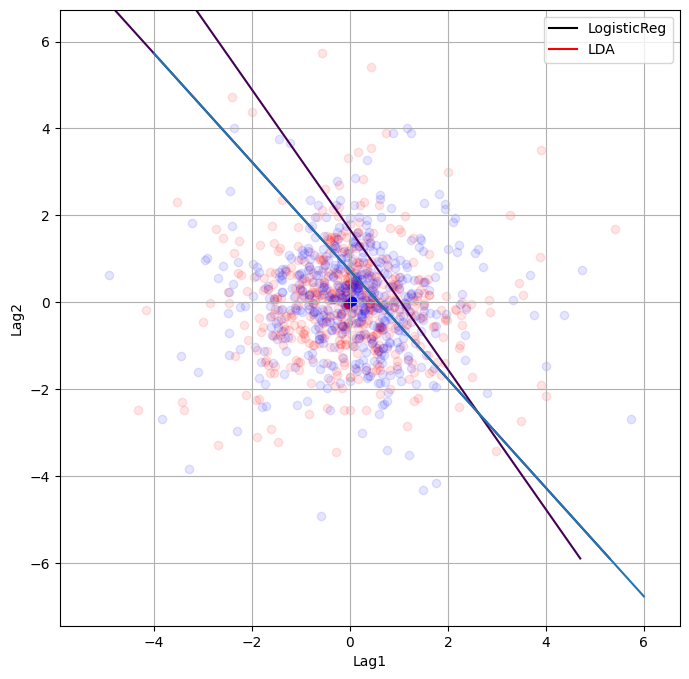

In [201]:
from matplotlib.pyplot import subplots
from sklearn.inspection import DecisionBoundaryDisplay

fig, ax = subplots(figsize=(8, 8))

complete_train_set = X_train.copy()
complete_train_set['result'] = y_train

ax.scatter(complete_train_set[complete_train_set['result']==True]['Lag1'], 
           complete_train_set[complete_train_set['result']==True]['Lag2'], 
           color='r', alpha=0.1)
ax.scatter(complete_train_set[complete_train_set['result']==True]['Lag1'].mean(),
           complete_train_set[complete_train_set['result']==True]['Lag2'].mean(),
           color='r')
ax.scatter(complete_train_set[complete_train_set['result']==False]['Lag1'], 
           complete_train_set[complete_train_set['result']==False]['Lag2'], 
           color='b', alpha=0.1)
ax.scatter(complete_train_set[complete_train_set['result']==False]['Lag1'].mean(),
           complete_train_set[complete_train_set['result']==False]['Lag2'].mean(),
           color='b')

DecisionBoundaryDisplay.from_estimator(
        clf,
        X[['Lag1','Lag2']],
        response_method="predict_proba",
        plot_method="contour",
        ax=ax,
        alpha=1.0,
        levels=[0.5]
    )

DecisionBoundaryDisplay.from_estimator(
        lda,
        X_train[['Lag1','Lag2']],
        response_method="predict_proba",
        plot_method="contour",
        ax=ax,
        alpha=1.0,
        levels=[0.5]
    )

# The decision boundary, as calculated from
# coeff_ \cdot x + intercept = 0
# coeff and intercept are general for any method.
x_lag1_axis = np.linspace(-4,6,10)
ax.plot(x_lag1_axis,-lda.coef_[0][0]/lda.coef_[0][1]*x_lag1_axis - lda.intercept_/lda.coef_[0][1])

# We have to create our custom legend because neither DecisionBoundaryDisplay nor its plot method `contour`accepts a label
from matplotlib.lines import Line2D
ax.legend(
    [Line2D([0], [0], color='k'), Line2D([0], [0], color='r')],
    ["LogisticReg", "LDA"],
    loc="upper right",
)

ax.grid(True)

If prior probabilities were the same, the line would go through the middle point between the two mean points for each class.

## Quadratic Discriminant Analysis
We will now fit a QDA model to the  `Smarket`  data. QDA is
implemented via
`QuadraticDiscriminantAnalysis()`
in the `sklearn` package, which we abbreviate to `QDA()`.
The syntax is very similar to `LDA()`.

```mermaid
flowchart TD
posteriori("a posteriori") --> gaussian("Gaussian")
posteriori --> ni("Not independent")
posteriori --> samevar("Difference variances, each class has its matrix") --> coef("p(p-1)/2 coefficients to estimate")
```

In [412]:
qda = QDA(store_covariance=True)
qda.fit(X_train, L_train)


QuadraticDiscriminantAnalysis(store_covariance=True)

The `QDA()` function will again compute `means_` and `priors_`.

In [413]:
qda.means_, qda.priors_

(array([[ 0.04279022,  0.03389409],
        [-0.03954635, -0.03132544]]),
 array([0.49198397, 0.50801603]))

In [414]:
qda.classes_

array(['Down', 'Up'], dtype=object)

The `QDA()` classifier will estimate one covariance per class. Here is the
estimated covariance in the first class:

In [415]:
qda.covariance_[0] # Covariance matrix for class 1: Down


array([[ 1.50662277, -0.03924806],
       [-0.03924806,  1.53559498]])

In [416]:
qda.covariance_[1] # Covariance matrix for the second class: Up

array([[ 1.51700576, -0.02787349],
       [-0.02787349,  1.49026815]])

The output contains the group means. But it does not contain the
coefficients of the linear discriminants, because the QDA classifier
involves a quadratic, rather than a linear, function of the
predictors. The `predict()`  function works in exactly the
same fashion as for LDA.

In [417]:
qda_pred = qda.predict(X_test)
confusion_table(qda_pred, L_test)


Truth,Down,Up
Predicted,,
Down,30,20
Up,81,121


Interestingly, the QDA predictions are accurate almost 60% of the
time, even though the 2005 data was not used to fit the model.

In [418]:
np.mean(qda_pred == L_test)

0.5992063492063492

In [419]:
complete_train_set

,Lag1,Lag2,result
0,0.381,-0.192,True
1,0.959,0.381,True
2,1.032,0.959,False
3,-0.623,1.032,True
4,0.614,-0.623,True
...,...,...,...
993,0.046,0.342,False
994,-0.431,0.046,True
995,0.715,-0.431,False
996,-0.007,0.715,True


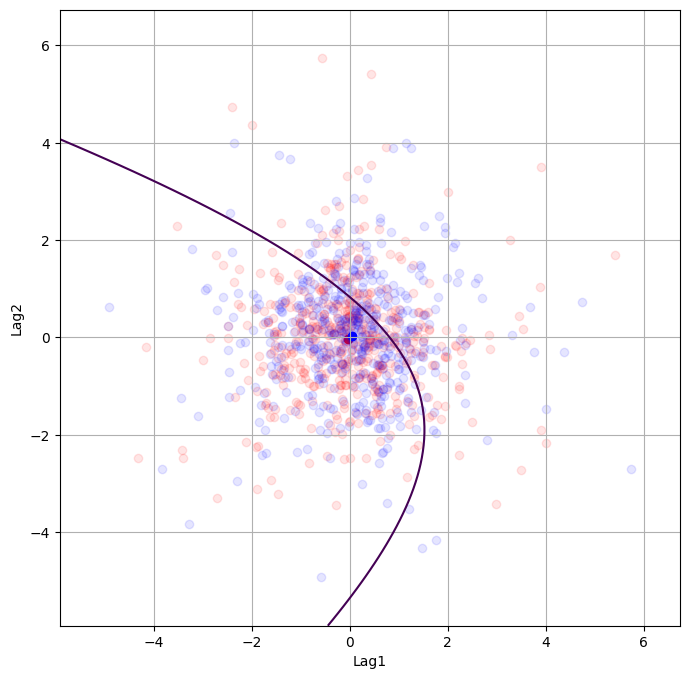

In [420]:
from matplotlib.pyplot import subplots
from sklearn.inspection import DecisionBoundaryDisplay

fig, ax = subplots(figsize=(8, 8))

ax.scatter(complete_train_set[complete_train_set['result']==True]['Lag1'], 
           complete_train_set[complete_train_set['result']==True]['Lag2'], 
           color='r', alpha=0.1)
ax.scatter(complete_train_set[complete_train_set['result']==True]['Lag1'].mean(),
           complete_train_set[complete_train_set['result']==True]['Lag2'].mean(),
           color='r')
ax.scatter(complete_train_set[complete_train_set['result']==False]['Lag1'], 
           complete_train_set[complete_train_set['result']==False]['Lag2'], 
           color='b', alpha=0.1)
ax.scatter(complete_train_set[complete_train_set['result']==False]['Lag1'].mean(),
           complete_train_set[complete_train_set['result']==False]['Lag2'].mean(),
           color='b')

DecisionBoundaryDisplay.from_estimator(
        qda,
        X_train[['Lag1','Lag2']],
        response_method="predict_proba",
        plot_method="contour",
        ax=ax,
        alpha=1.0,
        levels=[0.5]
    )

ax.grid(True)

This level of accuracy is quite impressive for stock market data, which is
known to be quite hard to model accurately.  This suggests that the
quadratic form assumed by QDA may capture the true relationship more
accurately than the linear forms assumed by LDA and logistic
regression.  However, we recommend evaluating this method’s
performance on a larger test set before betting that this approach
will consistently beat the market!

## Naive Bayes
Next, we fit a naive Bayes model to the `Smarket` data. The syntax is
similar to that of `LDA()` and `QDA()`. By
default, this implementation `GaussianNB()` of the naive Bayes classifier models each
quantitative feature using a Gaussian distribution. However, a kernel
density method can also be used to estimate the distributions.

```mermaid
flowchart TD
posteriori("a posteriori") --> anything("Can be anything") --> gaussian("GaussianNB uses Gaussians")
posteriori --> ni("independent")
```

In [327]:
NB = GaussianNB()
NB.fit(X_train, L_train)


GaussianNB()

The classes are stored as `classes_`.

In [328]:
NB.classes_


array(['Down', 'Up'], dtype='<U4')

The class prior probabilities are stored in the `class_prior_` attribute.

In [332]:
NB.class_prior_

array([0.49198397, 0.50801603])

The parameters of the features can be found in the `theta_` and `var_` attributes. The number of rows
is equal to the number of classes, while the number of columns is equal to the number of features.
We see below that the mean for feature `Lag1` in the `Down` class is 0.043.

In [335]:
NB.theta_
# 2 rows: 2 classes
# 2 columns: 2 features: Lag1 and Lag2

# And so the mean of the first gaussian used on the total 
# f_k(x) = f_k1(x) · f_k2(x) 
# is 0.0427 for Lag1 on the first class
# and is 0.0338 for Lag2 also on the first class.

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

Its variance is 1.503.

In [337]:
NB.var_
# In this case, the var follows the same approach.


array([[1.50355429, 1.53246749],
       [1.51401364, 1.48732877]])

How do we know the names of these attributes? We use `NB?` (or `?NB`).

We can easily verify the mean computation:

In [339]:
X_train[L_train == 'Down'].mean() # the means for class 1, just as the first row on NB.theta_


Lag1    0.042790
Lag2    0.033894
dtype: float64

Similarly for the variance:

In [340]:
X_train[L_train == 'Down'].var(ddof=0) # the variance for class 1, just as the first row on NB.var_


Lag1    1.503554
Lag2    1.532467
dtype: float64

Since `NB()` is a classifier in the `sklearn` library, making predictions
uses the same syntax as for `LDA()` and `QDA()` above.

In [341]:
nb_labels = NB.predict(X_test)
confusion_table(nb_labels, L_test)


Truth,Down,Up
Predicted,,
Down,29,20
Up,82,121


Naive Bayes performs well on these data, with accurate predictions over 59% of the time. This is slightly worse than QDA, but much better than LDA.

As for `LDA`, the `predict_proba()` method estimates the probability that each observation belongs to a particular class.

In [342]:
NB.predict_proba(X_test)[:5]


array([[0.4873288 , 0.5126712 ],
       [0.47623584, 0.52376416],
       [0.46529531, 0.53470469],
       [0.47484469, 0.52515531],
       [0.49020587, 0.50979413]])

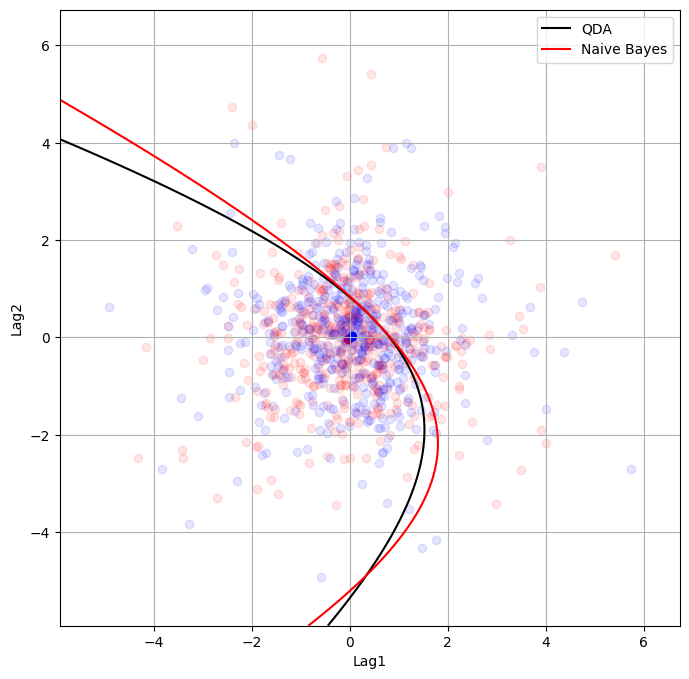

In [437]:
from matplotlib.pyplot import subplots
from sklearn.inspection import DecisionBoundaryDisplay

fig, ax = subplots(figsize=(8, 8))

ax.scatter(complete_train_set[complete_train_set['result']==True]['Lag1'], 
           complete_train_set[complete_train_set['result']==True]['Lag2'], 
           color='r', alpha=0.1)
ax.scatter(complete_train_set[complete_train_set['result']==True]['Lag1'].mean(),
           complete_train_set[complete_train_set['result']==True]['Lag2'].mean(),
           color='r')
ax.scatter(complete_train_set[complete_train_set['result']==False]['Lag1'], 
           complete_train_set[complete_train_set['result']==False]['Lag2'], 
           color='b', alpha=0.1)
ax.scatter(complete_train_set[complete_train_set['result']==False]['Lag1'].mean(),
           complete_train_set[complete_train_set['result']==False]['Lag2'].mean(),
           color='b')

DecisionBoundaryDisplay.from_estimator(
        qda,
        X_train[['Lag1','Lag2']],
        response_method="predict_proba",
        plot_method="contour",
        ax=ax,
        alpha=1.0,
        levels=[0.5],
        colors='black'
    )


DecisionBoundaryDisplay.from_estimator(
        NB,
        X_train[['Lag1','Lag2']],
        response_method="predict_proba",
        plot_method="contour",
        ax=ax,
        alpha=1.0,
        levels=[0.5],
        colors='red'
    )

# We have to create our custom legend because neither DecisionBoundaryDisplay nor its plot method `contour`accepts a label
from matplotlib.lines import Line2D
ax.legend(
    [Line2D([0], [0], color='k'), Line2D([0], [0], color='r')],
    ["QDA", "Naive Bayes"],
    loc="upper right",
)


ax.grid(True)

## K-Nearest Neighbors
- More variance.
- Lower bias.
  
We will now perform KNN using the `KNeighborsClassifier()` function. This function works similarly
to the other model-fitting functions that we have
encountered thus far.

As is the
case for LDA and QDA, we fit the classifier
using the `fit` method. New
predictions are formed using the `predict` method
of the object returned by `fit()`.

In [344]:
knn1 = KNeighborsClassifier(n_neighbors=1)

# Converts into numpy array the train and test sets.
X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]


knn1.fit(X_train, L_train)
knn1_pred = knn1.predict(X_test)
confusion_table(knn1_pred, L_test)


Truth,Down,Up
Predicted,,
Down,43,58
Up,68,83


The results using $K=1$ are not very good, since only $50%$ of the
observations are correctly predicted. Of course, it may be that $K=1$
results in an overly-flexible fit to the data.

In [345]:
(83+43)/252, np.mean(knn1_pred == L_test)


(0.5, 0.5)

We repeat the
analysis below using $K=3$.

In [346]:
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3_pred = knn3.fit(X_train, L_train).predict(X_test)
np.mean(knn3_pred == L_test)

0.5317460317460317

The results have improved slightly. But increasing *K* further
provides no further improvements. It appears that for these data, and this train/test split,
QDA gives the best results of the methods that we have examined so
far.

/home/jovyan/.local/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


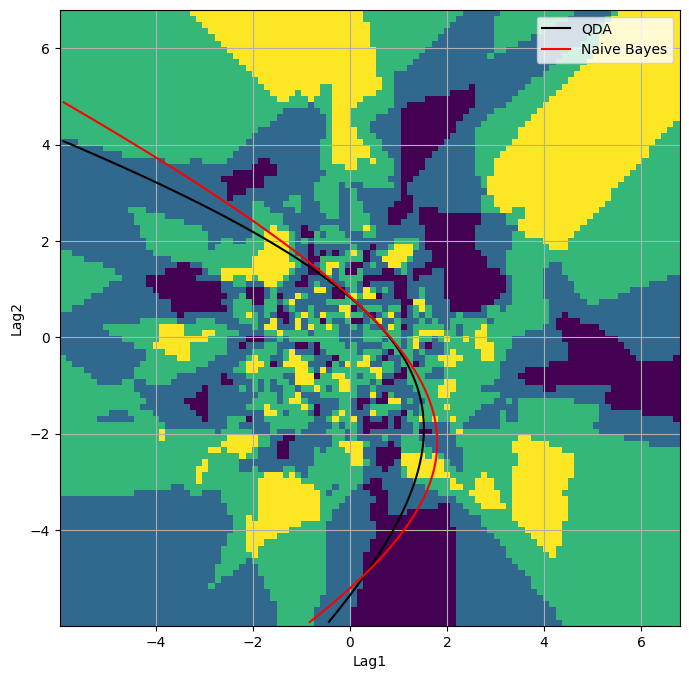

In [443]:
from matplotlib.pyplot import subplots
from sklearn.inspection import DecisionBoundaryDisplay

fig, ax = subplots(figsize=(8, 8))

ax.scatter(complete_train_set[complete_train_set['result']==True]['Lag1'], 
           complete_train_set[complete_train_set['result']==True]['Lag2'], 
           color='r', alpha=0.1)
ax.scatter(complete_train_set[complete_train_set['result']==True]['Lag1'].mean(),
           complete_train_set[complete_train_set['result']==True]['Lag2'].mean(),
           color='r')
ax.scatter(complete_train_set[complete_train_set['result']==False]['Lag1'], 
           complete_train_set[complete_train_set['result']==False]['Lag2'], 
           color='b', alpha=0.1)
ax.scatter(complete_train_set[complete_train_set['result']==False]['Lag1'].mean(),
           complete_train_set[complete_train_set['result']==False]['Lag2'].mean(),
           color='b')

DecisionBoundaryDisplay.from_estimator(
        qda,
        X_train[['Lag1','Lag2']],
        response_method="predict_proba",
        plot_method="contour",
        ax=ax,
        alpha=1.0,
        levels=[0.5],
        colors='black'
    )


DecisionBoundaryDisplay.from_estimator(
        NB,
        X_train[['Lag1','Lag2']],
        response_method="predict_proba",
        plot_method="contour",
        ax=ax,
        alpha=1.0,
        levels=[0.5],
        colors='red'
    )

DecisionBoundaryDisplay.from_estimator(
        knn3,
        X_train,
        response_method="predict_proba",
        plot_method="pcolormesh",
        ax=ax,
        alpha=1.0,
    )

# We have to create our custom legend because neither DecisionBoundaryDisplay nor its plot method `contour`accepts a label
from matplotlib.lines import Line2D
ax.legend(
    [Line2D([0], [0], color='k'), Line2D([0], [0], color='r')],
    ["QDA", "Naive Bayes"],
    loc="upper right",
)


ax.grid(True)

KNN does not perform well on the `Smarket`  data, but it often does provide impressive results. As an example we will apply the KNN approach to the `Caravan`  data set, which is part of the `ISLP` library.  This data set includes 85
predictors that measure demographic characteristics for 5,822
individuals. The response variable is  `Purchase`, which
indicates whether or not a given individual purchases a caravan
insurance policy. In this data set, only 6% of people purchased
caravan insurance.

In [349]:
Caravan = load_data('Caravan')
Purchase = Caravan.Purchase
Purchase.value_counts()


Purchase
No     5474
Yes     348
Name: count, dtype: int64

The method `value_counts()` takes a `pd.Series` or `pd.DataFrame` and returns
a `pd.Series` with the corresponding counts
for each unique element. In this case `Purchase` has only `Yes` and `No` values
and the method returns how many values of each there are.

In [350]:
348 / 5822


0.05977327378907592

Our features will include all columns except `Purchase`.

In [471]:
feature_df = Caravan.drop(columns=['Purchase'])
feature_df

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,0,1,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,0,1,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,0,1,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,0,1,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5817,36,1,1,2,8,0,6,1,2,1,...,2,0,0,0,1,0,0,0,0,0
5818,35,1,4,4,8,1,4,1,4,6,...,0,0,0,0,1,0,0,0,0,0
5819,33,1,3,4,8,0,6,0,3,5,...,0,0,0,0,1,0,0,0,0,0
5820,34,1,3,2,8,0,7,0,2,7,...,0,0,0,0,0,0,0,0,0,0


Because the KNN classifier predicts the class of a given test
observation by identifying the observations that are nearest to it,
the scale of the variables matters. Any variables that are on a large
scale will have a much larger effect on the *distance* between
the observations, and hence on the KNN classifier, than variables that
are on a small scale. For instance, imagine a data set that contains
two variables,  `salary`  and  `age`  (measured in dollars
and years, respectively). As far as KNN is concerned, a difference of
1,000 USD in salary is enormous compared to a difference of 50 years in
age. Consequently,  `salary`  will drive the KNN classification
results, and  `age`  will have almost no effect. This is contrary
to our intuition that a salary difference of 1,000 USD is quite small
compared to an age difference of 50 years.  Furthermore, the
importance of scale to the KNN classifier leads to another issue: if
we measured  `salary`  in Japanese yen, or if we measured
 `age`  in minutes, then we’d get quite different classification
results from what we get if these two variables are measured in
dollars and years.

A good way to handle this problem is to *standardize*  the data so that all variables are
given a mean of zero and a standard deviation of one. Then all
variables will be on a comparable scale. This is accomplished
using
the `StandardScaler()`
transformation.

In [472]:
scaler = StandardScaler(with_mean=True,
                        with_std=True,
                        copy=True)


The argument `with_mean` indicates whether or not
we should subtract the mean, while `with_std` indicates
whether or not we should scale the columns to have standard
deviation of 1 or not. Finally, the argument `copy=True`
indicates that we will always copy data, rather than
trying to do calculations in place where possible.

This transformation can be fit
and then applied to arbitrary data. In the first line
below, the parameters for the scaling are computed and
stored in `scaler`, while the second line actually
constructs the standardized set of features.

In [482]:
scaler.fit(feature_df)
X_std = scaler.transform(feature_df)
feature_std = pd.DataFrame(
                 X_std,
                 columns=feature_df.columns);
feature_std

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
0,0.680906,-0.27258,0.406697,-1.216964,0.779405,-0.694311,0.217444,-0.068711,-0.161816,0.427670,...,-0.202910,-0.073165,-0.081055,-0.05992,0.764971,-0.022706,-0.07365,-0.15062,-0.087348,-0.118816
1,0.992297,-0.27258,-0.859500,-1.216964,0.779405,0.302552,-0.365410,-0.068711,0.464159,-0.096077,...,-0.202910,-0.073165,-0.081055,-0.05992,0.764971,-0.022706,-0.07365,-0.15062,-0.087348,-0.118816
2,0.992297,-0.27258,-0.859500,-1.216964,0.779405,-0.694311,-0.365410,0.914172,0.464159,-1.667319,...,-0.202910,-0.073165,-0.081055,-0.05992,0.764971,-0.022706,-0.07365,-0.15062,-0.087348,-0.118816
3,-1.187437,-0.27258,0.406697,0.010755,-0.970980,1.299414,-0.948264,0.914172,0.464159,-0.619824,...,-0.202910,-0.073165,-0.081055,-0.05992,0.764971,-0.022706,-0.07365,-0.15062,-0.087348,-0.118816
4,1.225840,-0.27258,1.672893,-1.216964,1.479559,0.302552,-0.365410,-0.068711,0.464159,0.427670,...,-0.202910,-0.073165,-0.081055,-0.05992,0.764971,-0.022706,-0.07365,-0.15062,-0.087348,-0.118816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5817,0.914449,-0.27258,-2.125697,-1.216964,0.779405,-0.694311,0.800298,-0.068711,-0.787790,-2.714813,...,5.094585,-0.073165,-0.081055,-0.05992,0.764971,-0.022706,-0.07365,-0.15062,-0.087348,-0.118816
5818,0.836602,-0.27258,1.672893,1.238473,0.779405,0.302552,-0.365410,-0.068711,0.464159,-0.096077,...,-0.202910,-0.073165,-0.081055,-0.05992,0.764971,-0.022706,-0.07365,-0.15062,-0.087348,-0.118816
5819,0.680906,-0.27258,0.406697,1.238473,0.779405,-0.694311,0.800298,-1.051594,-0.161816,-0.619824,...,-0.202910,-0.073165,-0.081055,-0.05992,0.764971,-0.022706,-0.07365,-0.15062,-0.087348,-0.118816
5820,0.758754,-0.27258,0.406697,-1.216964,0.779405,-0.694311,1.383152,-1.051594,-0.787790,0.427670,...,-0.202910,-0.073165,-0.081055,-0.05992,-1.014358,-0.022706,-0.07365,-0.15062,-0.087348,-0.118816


Now every column of `feature_std` below has a standard deviation of
one and a mean of zero.

In [480]:
feature_std.std()

MOSTYPE     1.000086
MAANTHUI    1.000086
MGEMOMV     1.000086
MGEMLEEF    1.000086
MOSHOOFD    1.000086
              ...   
AZEILPL     1.000086
APLEZIER    1.000086
AFIETS      1.000086
AINBOED     1.000086
ABYSTAND    1.000086
Length: 85, dtype: float64

Notice that the standard deviations are not quite $1$ here; this is again due to some procedures using the $1/n$ convention for variances (in this case `scaler()`), while others use $1/(n-1)$ (the `std()` method). See the footnote on page 200.
In this case it does not matter, as long as the variables are all on the same scale.

Using the function `train_test_split()`  we now split the observations into a test set,
containing 1000 observations, and a training set containing the remaining
observations. The argument `random_state=0` ensures that we get
the same split each time we rerun the code.

In [458]:
(X_train,
 X_test,
 y_train,
 y_test) = train_test_split(np.asarray(feature_std),
                            Purchase,
                            test_size=1000,
                            random_state=0)


`?train_test_split` reveals that the non-keyword arguments can be `lists`, `arrays`, `pandas dataframes` etc that all have the same length (`shape[0]`) and hence are *indexable*. In this case they are the dataframe `feature_std` and the response variable `Purchase`.
 {Note that we have converted `feature_std` to an `ndarray` to address a bug in `sklearn`.}
We fit a KNN model on the training data using $K=1$,
and evaluate its performance on the test data.

In [459]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1_pred = knn1.fit(X_train, y_train).predict(X_test)
np.mean(y_test != knn1_pred), np.mean(y_test != "No")


(0.111, 0.067)

The KNN error rate on the 1,000 test observations is about $11%$.
At first glance, this may appear to be fairly good. However, **since
just over 6% of customers purchased insurance, we could get the error
rate down to almost 6% by always predicting `No` regardless of the
values of the predictors! This is known as the *null rate*.}**

Suppose that there is some non-trivial cost to trying to sell
insurance to a given individual. For instance, perhaps a salesperson
must visit each potential customer.  If the company tries to sell
insurance to a random selection of customers, then the success rate
will be only 6%, which may be far too low given the costs
involved.  Instead, the company would like to try to sell insurance
only to customers who are likely to buy it. So the overall error rate
is not of interest. Instead, the fraction of individuals that are
correctly predicted to buy insurance is of interest.

In [460]:
confusion_table(knn1_pred, y_test)


Truth,No,Yes
Predicted,,
No,880,58
Yes,53,9


It turns out that KNN with $K=1$ does far better than random guessing
among the customers that are predicted to buy insurance. Among 62
such customers, 9, or 14.5%, actually do purchase insurance.
This is double the rate that one would obtain from random guessing.

In [461]:
9/(53+9)

0.14516129032258066

# Tuning parameters

### Tuning Parameters

The number of neighbors in KNN is referred to as a ***tuning parameter*, also referred to as a *hyperparameter*.
We do not know *a priori* what value to use**. It is therefore of interest
to see how the classifier performs on test data as we vary these
parameters. This can be achieved with a `for` loop, described in Section 2.3.8.
Here we use a for loop to look at the accuracy of our classifier in the group predicted to purchase
insurance as we vary the number of neighbors from 1 to 5:

In [462]:
for K in range(1,6):
    knn = KNeighborsClassifier(n_neighbors=K)
    knn_pred = knn.fit(X_train, y_train).predict(X_test)
    C = confusion_table(knn_pred, y_test)
    templ = ('K={0:d}: # predicted to rent: {1:>2},' +
            '  # who did rent {2:d}, accuracy {3:.1%}')
    pred = C.loc['Yes'].sum()
    did_rent = C.loc['Yes','Yes']
    print(templ.format(
          K,
          pred,
          did_rent,
          did_rent / pred))


K=1: # predicted to rent: 62,  # who did rent 9, accuracy 14.5%
K=2: # predicted to rent:  6,  # who did rent 1, accuracy 16.7%
K=3: # predicted to rent: 20,  # who did rent 3, accuracy 15.0%
K=4: # predicted to rent:  4,  # who did rent 0, accuracy 0.0%
K=5: # predicted to rent:  7,  # who did rent 1, accuracy 14.3%


We see some variability ---  the numbers for `K=4` are very different from the rest.

### Comparison to Logistic Regression
As a comparison, we can also fit a logistic regression model to the
data. This can also be done
with `sklearn`, though by default it fits
something like the *ridge regression* version
of logistic regression, which we introduce in Chapter 6. This can
be modified by appropriately setting the argument `C` below. Its default
value is 1 but by setting it to a very large number, the algorithm converges to the same solution as the usual (unregularized)
logistic regression estimator discussed above.

Unlike the
`statsmodels` package, `sklearn` focuses less on
inference and more on classification. Hence,
the `summary` methods seen in `statsmodels`
and our simplified version seen with `summarize` are not
generally available for the classifiers in `sklearn`.

In [466]:
logit = LogisticRegression(C=1e10, solver='liblinear')
# What is linear is the logit, so we use Logistic Regression on the linear thing we are looking for.
logit.fit(X_train, y_train)
# We use predict proba and not predict like before.
logit_pred = logit.predict_proba(X_test)

# We label outcomes to either class depending on the probability we set.
# This considers only two classes and the threshold to be 0.5.
logit_labels = np.where(logit_pred[:,1] > .5, 'Yes', 'No')
confusion_table(logit_labels, y_test)

Truth,No,Yes
Predicted,,
No,931,67
Yes,2,0


We used the argument `solver='liblinear'` above to
avoid a warning with the default solver which would indicate that
the algorithm does not converge.

If we use $0.5$ as the predicted probability cut-off for the
classifier, then we have a problem: only two of the test observations
are predicted to purchase insurance.  However, we are not required to use a
cut-off of $0.5$. If we instead predict a purchase any time the
predicted probability of purchase exceeds $0.25$, we get much better
results: we predict that 29 people will purchase insurance, and we are
correct for about 31% of these people. This is almost five times
better than random guessing!

In [465]:
logit_labels = np.where(logit_pred[:,1]>0.25, 'Yes', 'No')
confusion_table(logit_labels, y_test)

Truth,No,Yes
Predicted,,
No,913,58
Yes,20,9


In [454]:
9/(20+9)


0.3103448275862069

In [468]:
X_test

array([[ 0.21382031, -0.27257995, -2.12569677, ..., -0.15062046,
        -0.08734772, -0.11881647],
       [ 0.52521092, -0.27257995,  1.67289335, ..., -0.15062046,
        -0.08734772, -0.11881647],
       [-1.18743745, -0.27257995,  0.40669664, ..., -0.15062046,
        -0.08734772, -0.11881647],
       ...,
       [ 0.60305857, -0.27257995, -0.85950007, ..., -0.15062046,
        -0.08734772, -0.11881647],
       [ 0.60305857, -0.27257995, -0.85950007, ..., -0.15062046,
        -0.08734772, -0.11881647],
       [-1.1095898 , -0.27257995,  1.67289335, ..., -0.15062046,
        -0.08734772, -0.11881647]])

## Linear and Poisson Regression on the Bikeshare Data
Here we fit linear and  Poisson regression models to the `Bikeshare` data, as described in Section 4.6.
The response `bikers` measures the number of bike rentals per hour
in Washington, DC in the period 2010--2012.

In [571]:
Bike = load_data('Bikeshare')

Let's have a peek at the dimensions and names of the variables in this dataframe.

In [572]:
Bike.shape, Bike.columns


((8645, 15),
 Index(['season', 'mnth', 'day', 'hr', 'holiday', 'weekday', 'workingday',
        'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
        'registered', 'bikers'],
       dtype='object'))

### Linear Regression

We begin by fitting a linear regression model to the data.

In [573]:
X = MS(['mnth',
        'hr',
        'workingday',
        'temp',
        'weathersit']).fit_transform(Bike)
Y = Bike['bikers']
M_lm = sm.OLS(Y, X).fit()
summarize(M_lm)


,coef,std err,t,P>|t|
intercept,-68.6317,5.307,-12.932,0.000
mnth[Feb],6.8452,4.287,1.597,0.110
mnth[March],16.5514,4.301,3.848,0.000
mnth[April],41.4249,4.972,8.331,0.000
mnth[May],72.5571,5.641,12.862,0.000
mnth[June],67.8187,6.544,10.364,0.000
mnth[July],45.3245,7.081,6.401,0.000
mnth[Aug],53.2430,6.640,8.019,0.000
mnth[Sept],66.6783,5.925,11.254,0.000
mnth[Oct],75.8343,4.950,15.319,0.000


There are 24 levels in `hr` and 40 rows in all.
In `M_lm`, the first levels `hr[0]` and `mnth[Jan]`  are treated
as the baseline values, and so no coefficient estimates are provided
for them: implicitly, their coefficient estimates are zero, and all
other levels are measured relative to these baselines. For example,
the Feb coefficient of $6.845$ signifies that, holding all other
variables constant, there are on average about 7 more riders in
February than in January. Similarly there are about 16.5 more riders
in March than in January.

The results seen in Section 4.6.1
used a slightly different coding of the variables `hr` and `mnth`, as follows:

In [577]:
hr_encode = contrast('hr', 'sum')
mnth_encode = contrast('mnth', 'sum')
# We make it so we are not using hr[0] and mnth[Jan] as baselines.
# Made it so the sum of the coefficients is 1.

In [575]:
hr_encode

Column(idx='hr', name='hr', is_categorical=True, is_ordinal=False, columns=(), encoder=Contrast(method='sum'))

Refitting again:

In [576]:
X2 = MS([mnth_encode, # we re-encoded month and hour
         hr_encode,
        'workingday',
        'temp',
        'weathersit']).fit_transform(Bike)
M2_lm = sm.OLS(Y, X2).fit()
S2 = summarize(M2_lm)
S2

,coef,std err,t,P>|t|
intercept,73.5974,5.132,14.340,0.000
mnth[Jan],-46.0871,4.085,-11.281,0.000
mnth[Feb],-39.2419,3.539,-11.088,0.000
mnth[March],-29.5357,3.155,-9.361,0.000
mnth[April],-4.6622,2.741,-1.701,0.089
mnth[May],26.4700,2.851,9.285,0.000
mnth[June],21.7317,3.465,6.272,0.000
mnth[July],-0.7626,3.908,-0.195,0.845
mnth[Aug],7.1560,3.535,2.024,0.043
mnth[Sept],20.5912,3.046,6.761,0.000


What is the difference between the two codings?  In `M2_lm`, a
coefficient estimate is reported for all but level `23` of `hr`
and level `Dec` of `mnth`. **Importantly, in `M2_lm`, the (unreported) coefficient estimate
for the last level of `mnth` is not zero: instead, it equals the
negative of the sum of the coefficient estimates for all of the
other levels**. Similarly, in `M2_lm`, the coefficient estimate
for the last level of `hr` is the negative of the sum of the
coefficient estimates for all of the other levels. This means that the
coefficients of `hr` and `mnth` in `M2_lm` will always sum
to zero, and **can be interpreted as the difference from the mean
level**. For example, the coefficient for January of $-46.087$ indicates
that, holding all other variables constant, there are typically 46
fewer riders in January relative to the yearly average.

It is important to realize that the choice of coding really does not
matter, provided that we interpret the  model output correctly in light
of the coding used. For example, we see that the predictions from the
linear model are the same regardless of coding:

In [578]:
np.sum((M_lm.fittedvalues - M2_lm.fittedvalues)**2)


1.5178478088943298e-20

The sum of squared differences is zero. We can also see this using the
`np.allclose()` function:

In [70]:
np.allclose(M_lm.fittedvalues, M2_lm.fittedvalues)


True

To reproduce the left-hand side of Figure 4.13
we must first obtain the coefficient estimates associated with
`mnth`. The coefficients for January through November can be obtained
directly from the `M2_lm` object. The coefficient for December
must be explicitly computed as the negative sum of all the other
months. We first extract all the coefficients for month from
the coefficients of `M2_lm`.

In [579]:
coef_month = S2[S2.index.str.contains('mnth')]['coef']
coef_month


mnth[Jan]     -46.0871
mnth[Feb]     -39.2419
mnth[March]   -29.5357
mnth[April]    -4.6622
mnth[May]      26.4700
mnth[June]     21.7317
mnth[July]     -0.7626
mnth[Aug]       7.1560
mnth[Sept]     20.5912
mnth[Oct]      29.7472
mnth[Nov]      14.2229
Name: coef, dtype: float64

Next, we append `Dec` as the negative of the sum of all other months.

In [580]:
months = Bike['mnth'].dtype.categories
coef_month = pd.concat([
                       coef_month,
                       pd.Series([-coef_month.sum()],
                                  index=['mnth[Dec]'
                                 ])
                       ])
coef_month


mnth[Jan]     -46.0871
mnth[Feb]     -39.2419
mnth[March]   -29.5357
mnth[April]    -4.6622
mnth[May]      26.4700
mnth[June]     21.7317
mnth[July]     -0.7626
mnth[Aug]       7.1560
mnth[Sept]     20.5912
mnth[Oct]      29.7472
mnth[Nov]      14.2229
mnth[Dec]       0.3705
dtype: float64

Finally, to make the plot neater, we’ll just use the first letter of each month, which is the $6$th entry of each of
the labels in the index.

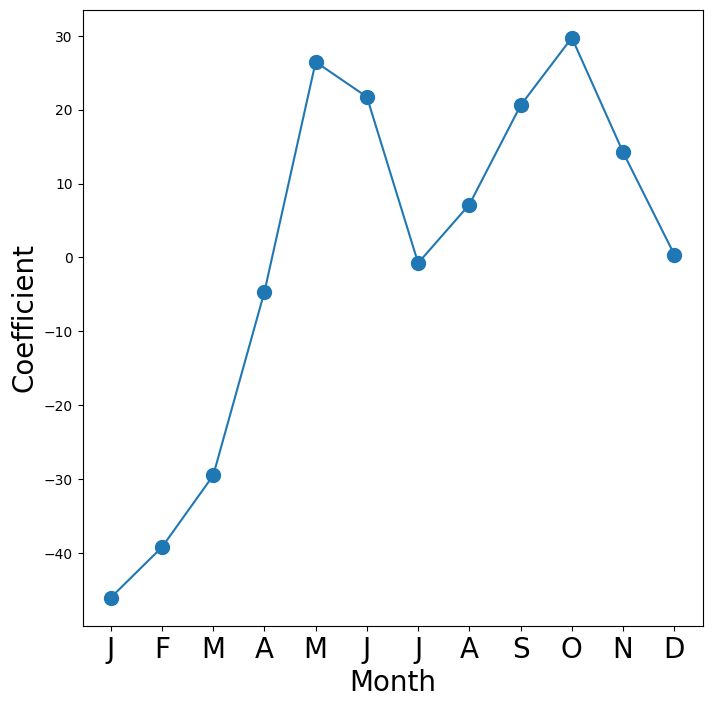

In [581]:
fig_month, ax_month = subplots(figsize=(8,8))
x_month = np.arange(coef_month.shape[0])
ax_month.plot(x_month, coef_month, marker='o', ms=10)
ax_month.set_xticks(x_month)
ax_month.set_xticklabels([l[5] for l in coef_month.index], fontsize=20)
ax_month.set_xlabel('Month', fontsize=20)
ax_month.set_ylabel('Coefficient', fontsize=20);


Reproducing the  right-hand plot in Figure 4.13  follows a similar process.

In [582]:
coef_hr = S2[S2.index.str.contains('hr')]['coef']
coef_hr = coef_hr.reindex(['hr[{0}]'.format(h) for h in range(23)])
coef_hr = pd.concat([coef_hr,
                     pd.Series([-coef_hr.sum()], index=['hr[23]'])
                    ])


We now make the hour plot.

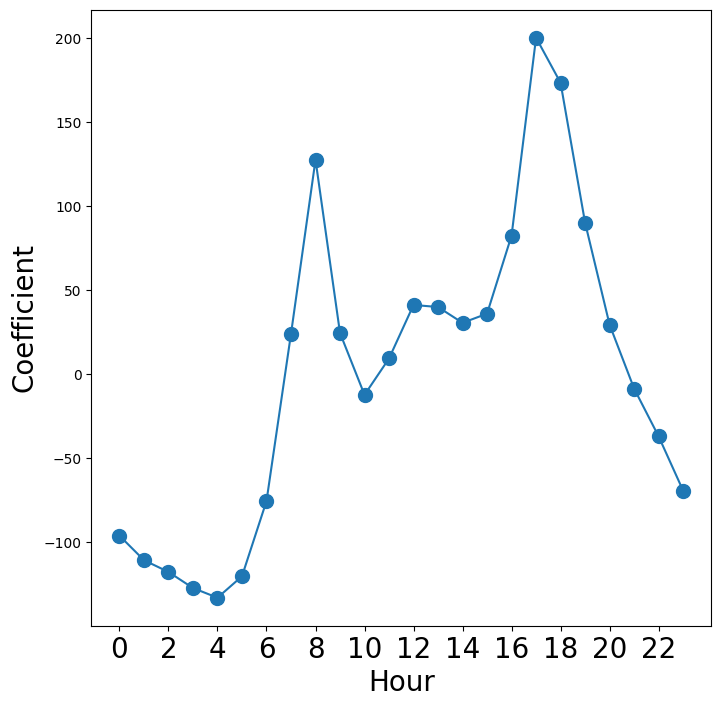

In [583]:
fig_hr, ax_hr = subplots(figsize=(8,8))
x_hr = np.arange(coef_hr.shape[0])
ax_hr.plot(x_hr, coef_hr, marker='o', ms=10)
ax_hr.set_xticks(x_hr[::2])
ax_hr.set_xticklabels(range(24)[::2], fontsize=20)
ax_hr.set_xlabel('Hour', fontsize=20)
ax_hr.set_ylabel('Coefficient', fontsize=20);


### Poisson Regression

Now we fit instead a Poisson regression model to the
`Bikeshare` data. Very little changes, except that we now use the
function `sm.GLM()` with the Poisson family specified:

In [585]:
M_pois = sm.GLM(Y, X2, family=sm.families.Poisson()).fit()


We can plot the coefficients associated with `mnth` and `hr`, in order to reproduce  Figure 4.15. We first complete these coefficients as before.

In [591]:
S_pois = summarize(M_pois)
S_pois

,coef,std err,z,P>|z|
intercept,4.1182,0.006,683.963,0.0
mnth[Jan],-0.6702,0.006,-113.445,0.0
mnth[Feb],-0.4441,0.005,-91.379,0.0
mnth[March],-0.2937,0.004,-70.886,0.0
mnth[April],0.0215,0.003,6.888,0.0
mnth[May],0.2405,0.003,82.462,0.0
mnth[June],0.2232,0.004,62.818,0.0
mnth[July],0.1036,0.004,25.121,0.0
mnth[Aug],0.1512,0.004,41.281,0.0
mnth[Sept],0.2335,0.003,75.281,0.0


In [592]:
coef_month = S_pois[S_pois.index.str.contains('mnth')]['coef']
coef_month = pd.concat([coef_month,
                        pd.Series([-coef_month.sum()],
                                   index=['mnth[Dec]'])])
coef_hr = S_pois[S_pois.index.str.contains('hr')]['coef']
coef_hr = pd.concat([coef_hr,
                     pd.Series([-coef_hr.sum()],
                     index=['hr[23]'])])

The plotting is as before.

/tmp/ipykernel_185/3779905754.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_hr.set_xticklabels(range(24)[::2], fontsize=20)


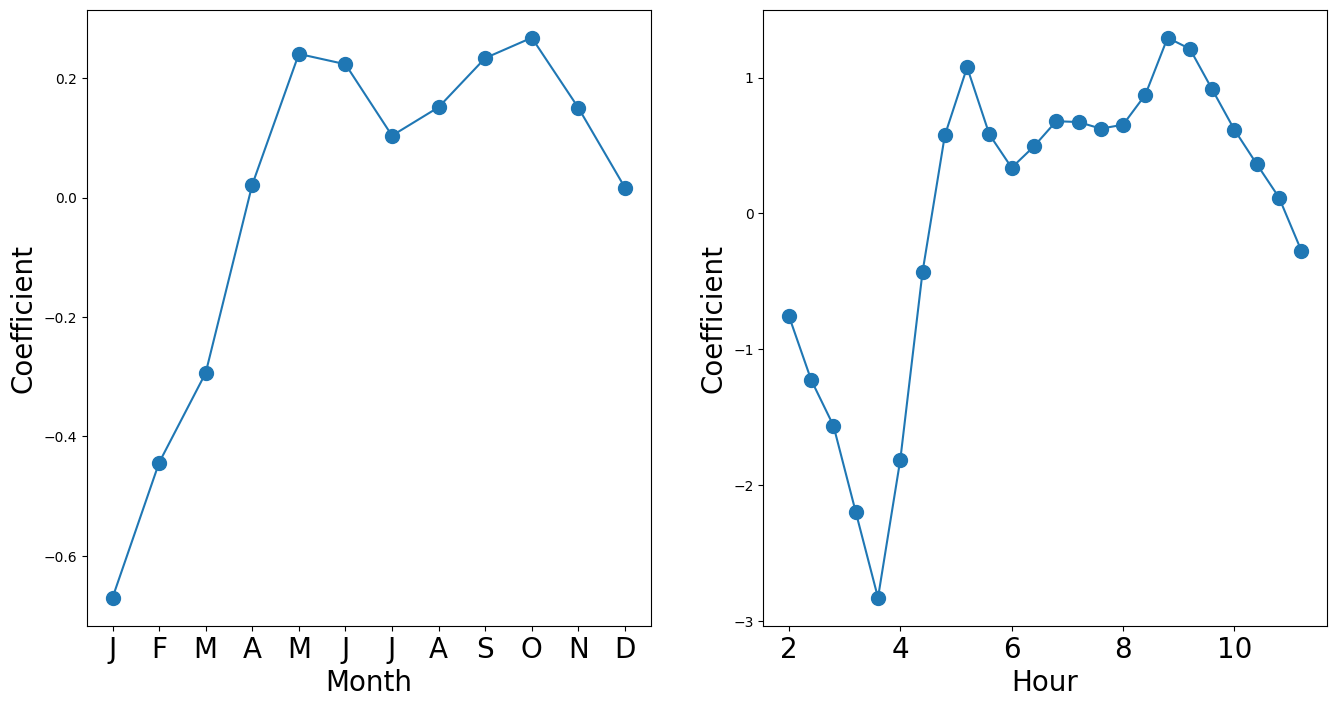

In [593]:
fig_pois, (ax_month, ax_hr) = subplots(1, 2, figsize=(16,8))
ax_month.plot(x_month, coef_month, marker='o', ms=10)
ax_month.set_xticks(x_month)
ax_month.set_xticklabels([l[5] for l in coef_month.index], fontsize=20)
ax_month.set_xlabel('Month', fontsize=20)
ax_month.set_ylabel('Coefficient', fontsize=20)
ax_hr.plot(x_hr, coef_hr, marker='o', ms=10)
ax_hr.set_xticklabels(range(24)[::2], fontsize=20)
ax_hr.set_xlabel('Hour', fontsize=20)
ax_hr.set_ylabel('Coefficient', fontsize=20);


We compare the fitted values of the two models.
The fitted values are stored in the `fittedvalues` attribute
returned by the `fit()` method for both the linear regression and the Poisson
fits. The linear predictors are stored as the attribute `lin_pred`.

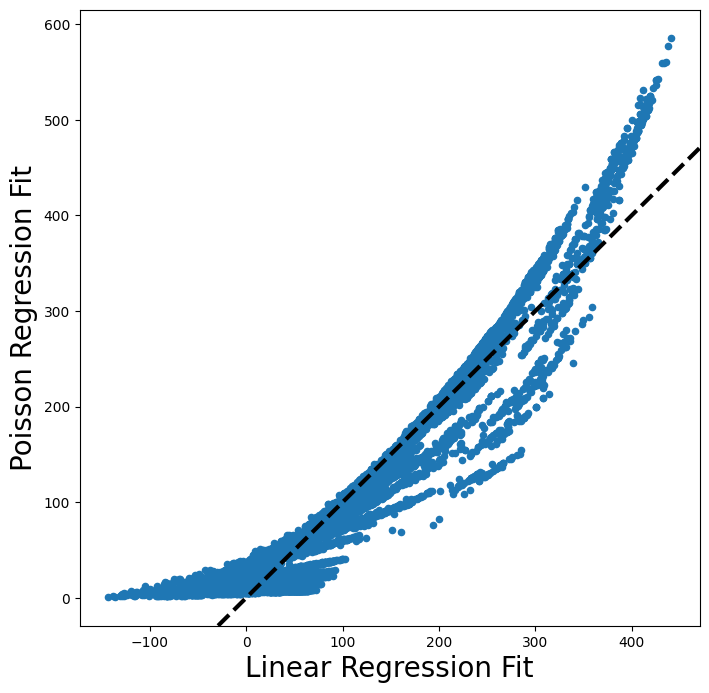

In [594]:
fig, ax = subplots(figsize=(8, 8))
ax.scatter(M2_lm.fittedvalues,
           M_pois.fittedvalues,
           s=20)
ax.set_xlabel('Linear Regression Fit', fontsize=20)
ax.set_ylabel('Poisson Regression Fit', fontsize=20)
ax.axline([0,0], c='black', linewidth=3,
          linestyle='--', slope=1);


The predictions from the Poisson regression model are correlated with
those from the linear model; however, the former are non-negative. As
a result the Poisson regression predictions tend to be larger than
those from the linear model for either very low or very high levels of
ridership.

In this section, we fit Poisson regression models using the `sm.GLM()` function with the argument
`family=sm.families.Poisson()`. Earlier in this lab we used the `sm.GLM()` function
with `family=sm.families.Binomial()` to perform logistic regression. Other
choices for the `family` argument can be used to fit other types
of GLMs. For instance, `family=sm.families.Gamma()` fits a Gamma regression
model.

